# WindFlow

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [19]:
viento_url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/main/output/viento_dmc/2022/2022_viento_dmc.csv'
temp_url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/main/output/temperatura_dmc/2022/2022_temperatura_dmc.csv'
rocio_url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/main/output/rocio_dmc/2022/2022_rocio_dmc.csv'
humedad_url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/main/output/humedad_dmc/2022/2022_humedad_dmc.csv'
qff_url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/main/output/presionqff_dmc/2022/2022_presionqff_dmc.csv'
qfe_url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/main/output/presionqfe_dmc/2022/2022_presionqfe_dmc.csv'

In [66]:
def select_estacion(url, estacion):
    df = pd.read_csv(url)
    df = df[df['nombreEstacion']==estacion].copy()
    df.drop(columns=['latitud', 'longitud', 'CodigoNacional', 'nombreEstacion'], inplace = True)
    df.set_index('time', inplace = True)
    return df

In [67]:
calama = 'El Loa, Calama Ad.'
features_url = [viento_url, temp_url, rocio_url, humedad_url, qff_url, qfe_url]

In [120]:
from functools import reduce

dfList = [select_estacion(url, calama) for url in features_url]
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='time'), dfList)

In [71]:
df.head()

,dd_Valor,ff_Valor,VRB_Valor,Ts_Valor,Td_Valor,HR_Valor,QFF_Valor,QFE_Valor
time,,,,,,,,
2022-01-01 01:00:00,239.0,13.0,0.0,17.2,2.1,36.0,1019.4,772.1
2022-01-01 02:00:00,230.0,7.0,0.0,16.1,2.2,39.0,1020.9,772.4
2022-01-01 03:00:00,104.0,2.0,0.0,13.8,1.2,42.0,1023.4,772.6
2022-01-01 04:00:00,85.0,8.0,0.0,12.0,0.2,44.0,1025.1,772.3
2022-01-01 05:00:00,112.0,13.0,0.0,10.3,-0.2,48.0,1026.0,771.8


In [121]:
#Transformamos la variable date a timestamp
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6439 entries, 2022-01-01 01:00:00 to 2022-09-29 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dd_Valor   6302 non-null   float64
 1   ff_Valor   6439 non-null   float64
 2   VRB_Valor  6439 non-null   float64
 3   Ts_Valor   6439 non-null   float64
 4   Td_Valor   6439 non-null   float64
 5   HR_Valor   6439 non-null   float64
 6   QFF_Valor  6439 non-null   float64
 7   QFE_Valor  6439 non-null   float64
dtypes: float64(8)
memory usage: 452.7 KB


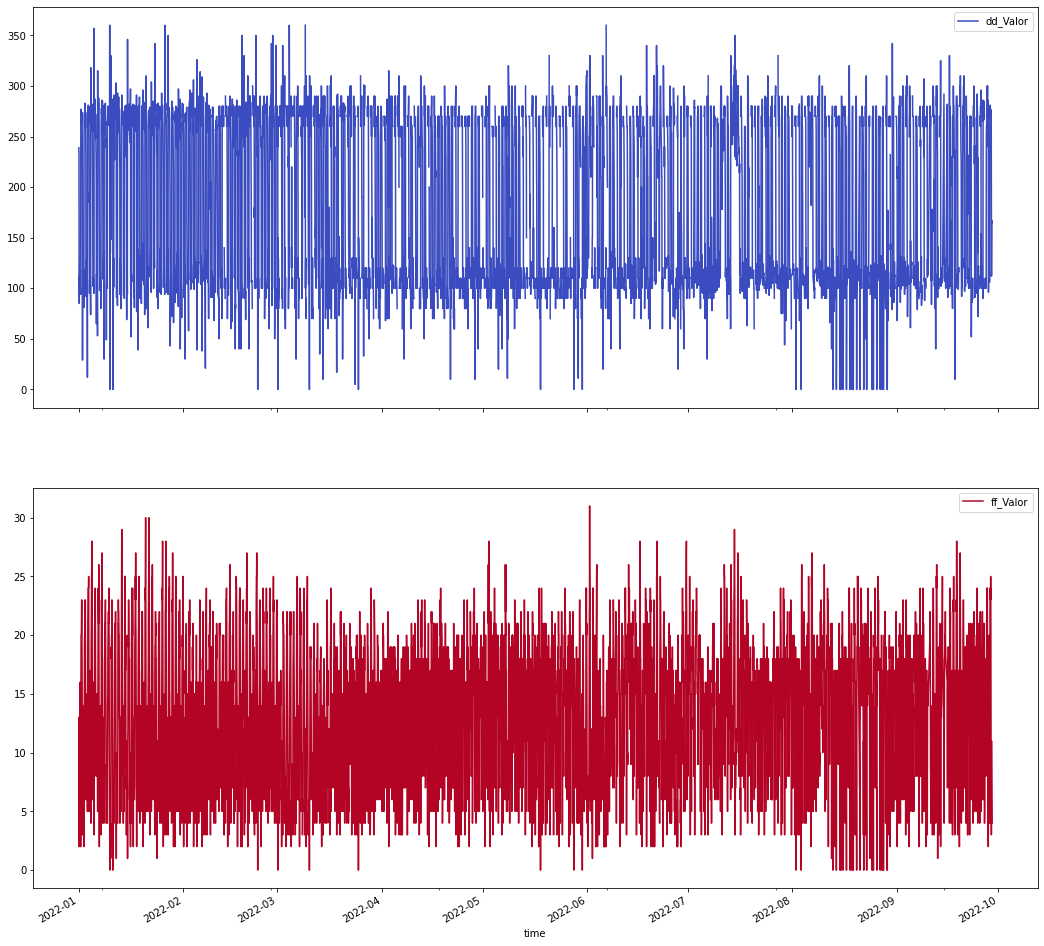

In [74]:
df[['dd_Valor', 'ff_Valor']].plot(kind='line', figsize = (18,18), cmap='coolwarm', subplots = True, fontsize = 10)
plt.show()

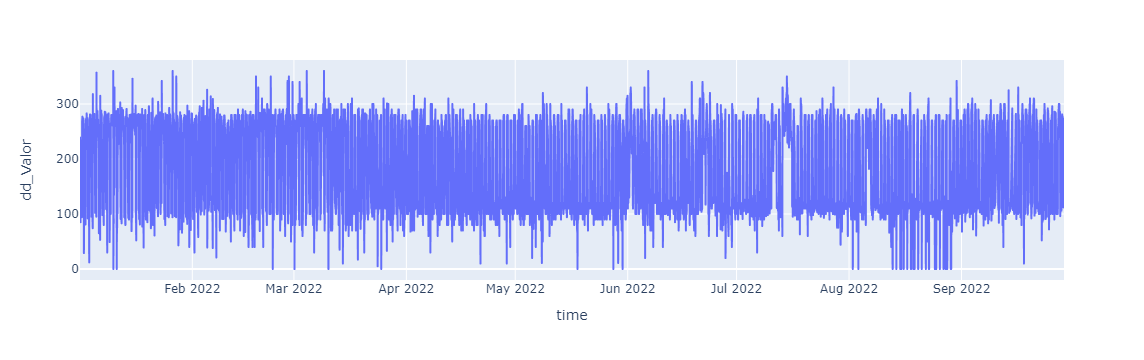

In [211]:
import plotly.express as px
fig = px.line(df, x=df.index, y="dd_Valor")
fig.show()

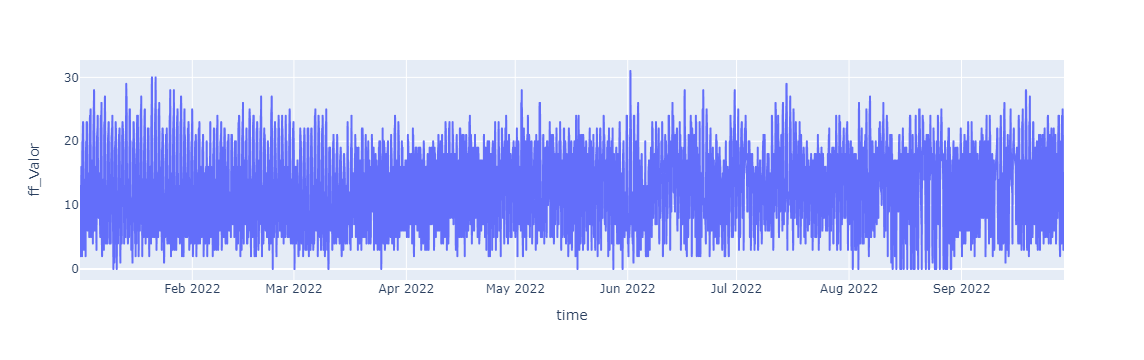

In [210]:
fig = px.line(df, x=df.index, y="ff_Valor")
fig.show()

In [124]:
df = df.interpolate(method='linear', limit_direction='forward', axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6439 entries, 2022-01-01 01:00:00 to 2022-09-29 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dd_Valor   6439 non-null   float64
 1   ff_Valor   6439 non-null   float64
 2   VRB_Valor  6439 non-null   float64
 3   Ts_Valor   6439 non-null   float64
 4   Td_Valor   6439 non-null   float64
 5   HR_Valor   6439 non-null   float64
 6   QFF_Valor  6439 non-null   float64
 7   QFE_Valor  6439 non-null   float64
dtypes: float64(8)
memory usage: 452.7 KB


## Feature Engineering

In [125]:
def toCircular(df, wd):
    df['sin_wd']=np.sin(df[wd]/360*2*math.pi)
    df['cos_wd']=np.cos(df[wd]/360*2*math.pi)
    print("toCircular columns created")
    return df

df = toCircular(df, 'dd_Valor')

toCircular columns created


In [ ]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
        
df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [126]:
df['month'] = df.index.month ## Anadimos columna month
df['day'] = df.index.day ## Anadimos columna dia
df['hour'] = df.index.hour ## Anadimos columna hora

In [127]:
df_forecasting = df.copy()

In [128]:
df_forecasting.head()

,dd_Valor,ff_Valor,VRB_Valor,Ts_Valor,Td_Valor,HR_Valor,QFF_Valor,QFE_Valor,sin_wd,cos_wd,month,day,hour
time,,,,,,,,,,,,,
2022-01-01 01:00:00,239.0,13.0,0.0,17.2,2.1,36.0,1019.4,772.1,-0.857167,-0.515038,1,1,1
2022-01-01 02:00:00,230.0,7.0,0.0,16.1,2.2,39.0,1020.9,772.4,-0.766044,-0.642788,1,1,2
2022-01-01 03:00:00,104.0,2.0,0.0,13.8,1.2,42.0,1023.4,772.6,0.970296,-0.241922,1,1,3
2022-01-01 04:00:00,85.0,8.0,0.0,12.0,0.2,44.0,1025.1,772.3,0.996195,0.087156,1,1,4
2022-01-01 05:00:00,112.0,13.0,0.0,10.3,-0.2,48.0,1026.0,771.8,0.927184,-0.374607,1,1,5


In [133]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [135]:
df2 = series_to_supervised(df_forecasting)

In [137]:
pd.DataFrame(df2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,239.0,13.0,0.0,17.2,2.1,36.0,1019.4,772.1,-0.857167,-0.515038,...,16.1,2.2,39.0,1020.9,772.4,-0.766044,-0.642788,1.0,1.0,2.0
1,230.0,7.0,0.0,16.1,2.2,39.0,1020.9,772.4,-0.766044,-0.642788,...,13.8,1.2,42.0,1023.4,772.6,0.970296,-0.241922,1.0,1.0,3.0
2,104.0,2.0,0.0,13.8,1.2,42.0,1023.4,772.6,0.970296,-0.241922,...,12.0,0.2,44.0,1025.1,772.3,0.996195,0.087156,1.0,1.0,4.0
3,85.0,8.0,0.0,12.0,0.2,44.0,1025.1,772.3,0.996195,0.087156,...,10.3,-0.2,48.0,1026.0,771.8,0.927184,-0.374607,1.0,1.0,5.0
4,112.0,13.0,0.0,10.3,-0.2,48.0,1026.0,771.8,0.927184,-0.374607,...,8.7,-0.6,52.0,1027.6,771.7,0.974370,-0.224951,1.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,269.0,10.0,0.0,7.5,-22.4,10.0,1029.6,772.4,-0.999848,-0.017452,...,4.9,-22.4,12.0,1033.3,773.0,0.241922,-0.970296,9.0,29.0,2.0
6434,166.0,3.0,0.0,4.9,-22.4,12.0,1033.3,773.0,0.241922,-0.970296,...,3.1,-21.3,15.0,1035.5,773.1,0.927184,-0.374607,9.0,29.0,3.0
6435,112.0,11.0,0.0,3.1,-21.3,15.0,1035.5,773.1,0.927184,-0.374607,...,1.9,-18.3,21.0,1036.2,772.7,0.656059,-0.754710,9.0,29.0,4.0
6436,139.0,7.0,0.0,1.9,-18.3,21.0,1036.2,772.7,0.656059,-0.754710,...,2.1,-15.6,26.0,1035.7,772.4,0.224951,-0.974370,9.0,29.0,5.0


## Training

In [140]:
# Separamos nuestra data en train y test set

x = df_forecasting.drop(columns = 'dd_Valor')
y = df_forecasting['dd_Valor']
x_train, x_test = x.loc[x.index < '2022-08-01'], x.loc[x.index >= '2022-08-01'] 
y_train, y_test = y.loc[y.index < '2022-08-01'], y.loc[y.index >= '2022-08-01']
index_col = x_test.index
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5069, 12) (5069,)
(1370, 12) (1370,)


In [142]:
df_train, df_test = df.loc[df.index < '2022-08-01'], df.loc[df.index >= '2022-08-01']

In [143]:
df_train.head()

,dd_Valor,ff_Valor,VRB_Valor,Ts_Valor,Td_Valor,HR_Valor,QFF_Valor,QFE_Valor,sin_wd,cos_wd,month,day,hour
time,,,,,,,,,,,,,
2022-01-01 01:00:00,239.0,13.0,0.0,17.2,2.1,36.0,1019.4,772.1,-0.857167,-0.515038,1,1,1
2022-01-01 02:00:00,230.0,7.0,0.0,16.1,2.2,39.0,1020.9,772.4,-0.766044,-0.642788,1,1,2
2022-01-01 03:00:00,104.0,2.0,0.0,13.8,1.2,42.0,1023.4,772.6,0.970296,-0.241922,1,1,3
2022-01-01 04:00:00,85.0,8.0,0.0,12.0,0.2,44.0,1025.1,772.3,0.996195,0.087156,1,1,4
2022-01-01 05:00:00,112.0,13.0,0.0,10.3,-0.2,48.0,1026.0,771.8,0.927184,-0.374607,1,1,5


### fbprophet

In [152]:
from fbprophet import Prophet

train = df_train.reset_index()
train.rename(columns={'dd_Valor':'y', 'time':'ds'}, inplace = True)
train.head()

,ds,y,ff_Valor,VRB_Valor,Ts_Valor,Td_Valor,HR_Valor,QFF_Valor,QFE_Valor,sin_wd,cos_wd,month,day,hour
0,2022-01-01 01:00:00,239.0,13.0,0.0,17.2,2.1,36.0,1019.4,772.1,-0.857167,-0.515038,1,1,1
1,2022-01-01 02:00:00,230.0,7.0,0.0,16.1,2.2,39.0,1020.9,772.4,-0.766044,-0.642788,1,1,2
2,2022-01-01 03:00:00,104.0,2.0,0.0,13.8,1.2,42.0,1023.4,772.6,0.970296,-0.241922,1,1,3
3,2022-01-01 04:00:00,85.0,8.0,0.0,12.0,0.2,44.0,1025.1,772.3,0.996195,0.087156,1,1,4
4,2022-01-01 05:00:00,112.0,13.0,0.0,10.3,-0.2,48.0,1026.0,771.8,0.927184,-0.374607,1,1,5


In [157]:
model=Prophet(interval_width=0.9)
model.add_regressor('ff_Valor', standardize = False)
model.add_regressor('Ts_Valor', standardize = False)
model.add_regressor('Td_Valor', standardize = False)
model.add_regressor('HR_Valor', standardize = False)
model.add_regressor('QFF_Valor', standardize = False)
model.add_regressor('QFE_Valor', standardize = False)
model.add_regressor('sin_wd', standardize = False)
model.add_regressor('cos_wd', standardize = False)
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -249.019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8608.8    0.00467418        233718     0.01484           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          9212    0.00153366       77190.7    0.001149           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       11602.5    0.00490076        985119      0.2402      0.9038      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       11713.4   0.000482143        235715           1           1      688   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       11860.9   6.40274e-06       54400.5           1           1      842   
    Iter      log prob        ||dx||      ||grad||       alpha  

  11893.8   8.50452e-06       48028.2      0.3817           1      970   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       11902.4   0.000403602       14725.1           1           1     1109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       11910.4   0.000133079       27794.4           1           1     1254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     879       11916.5   2.96599e-06          4397      0.1909           1     1400   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [158]:
model.params

{'k': array([[0.08689375]]),
 'm': array([[0.66401363]]),
 'delta': array([[-0.01621214, -0.01570514, -0.01481168, -0.01369892, -0.01233574,
         -0.01060595, -0.00878195, -0.00709511, -0.00528108, -0.00334669,
         -0.00200637, -0.0002641 ,  0.00129981,  0.0028008 ,  0.00386107,
          0.00496903,  0.00602234,  0.00659589,  0.01173782, -0.01794481,
         -0.00122307, -0.00173435,  0.00998681,  0.00824711,  0.00822381]]),
 'sigma_obs': array([[0.05955101]]),
 'beta': array([[ 7.73004090e-04,  1.15556120e-03, -1.56811392e-03,
         -6.34531790e-04, -7.06233371e-04, -4.16835330e-04,
          3.96706386e-03, -1.02392456e-02,  1.57936150e-03,
         -4.25319851e-03, -3.28478033e-03, -9.67688932e-04,
          1.43478103e-03, -2.48884426e-03,  2.39433195e-03,
         -1.37425244e-03, -7.33235747e-04,  2.45857306e-04,
         -9.27514331e-04,  9.95508246e-04, -2.49571412e-01,
          2.88925735e-03]]),
 'trend': array([[0.66401363, 0.66403072, 0.6640478 , ..., 0.67235

In [167]:
test = df_test.reset_index()
test.rename(columns={'time':'ds'}, inplace = True)
test = test.drop(columns = 'dd_Valor')
test.head()

,ds,ff_Valor,VRB_Valor,Ts_Valor,Td_Valor,HR_Valor,QFF_Valor,QFE_Valor,sin_wd,cos_wd,month,day,hour
0,2022-08-01 00:00:00,7.0,0.0,13.7,-13.4,14.0,1024.5,773.1,-1.000000,-1.836970e-16,8,1,0
1,2022-08-01 01:00:00,9.0,0.0,10.3,-15.3,15.0,1028.5,773.7,0.358368,-9.335804e-01,8,1,1
2,2022-08-01 02:00:00,7.0,0.0,7.8,-15.2,18.0,1031.9,774.1,0.754710,-6.560590e-01,8,1,2
3,2022-08-01 03:00:00,9.0,0.0,7.5,-12.9,22.0,1032.6,774.4,0.891007,-4.539905e-01,8,1,3
4,2022-08-01 04:00:00,17.0,0.0,6.7,-15.4,19.0,1033.4,774.3,0.920505,-3.907311e-01,8,1,4


In [169]:
forecast1 = model.predict(test)
forecast1[['ds', 'yhat']]

,ds,yhat
0,2022-08-01 00:00:00,263.649333
1,2022-08-01 01:00:00,144.632010
2,2022-08-01 02:00:00,110.324995
3,2022-08-01 03:00:00,102.076671
4,2022-08-01 04:00:00,108.576340
...,...,...
1365,2022-09-29 02:00:00,157.299206
1366,2022-09-29 03:00:00,105.679491
1367,2022-09-29 04:00:00,127.827535
1368,2022-09-29 05:00:00,166.340828


In [205]:
y_true = df_test.reset_index()[['dd_Valor']]
y_pred = forecast1[['yhat']]
#pd.concat((y_pred, y_true), axis = 1)

In [207]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MAE_fb = mean_absolute_error(y_true, y_pred)
MSE_fb = mean_squared_error(y_true, y_pred)
RMSE_fb = mean_squared_error(y_true, y_pred, squared=False)
R2_fb = r2_score(y_true, y_pred)


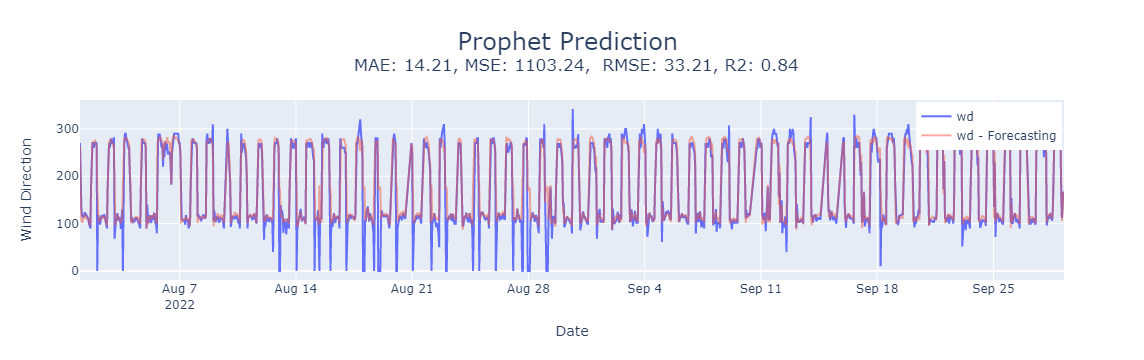

In [209]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x = df_test.index, y = df_test['dd_Valor'], mode='lines', name='wd'))
fig.add_trace(go.Scatter(x = forecast1['ds'], y = forecast1['yhat'], mode='lines', name='wd - Forecasting', opacity=0.5))

fig.update_layout(title_text=f'Prophet Prediction <br> <sup> MAE: {MAE_fb:.2f}, MSE: {MSE_fb:.2f},  RMSE: {RMSE_fb:.2f}, R2: {R2_fb:.2f} </sup>',
                  title_font_size=24, title_x=0.5)
fig.update_yaxes(title_text="Wind Direction")
fig.update_xaxes(title_text="Date")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.85
))
fig.show()

### Random forest

In [112]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 0)
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

y_pred=rf.predict(x_test)

MAE_rf = mean_absolute_error(y_test, y_pred) #MAE
MSE_rf = mean_squared_error(y_test, y_pred) # MSE
RMSE_rf = mean_squared_error(y_test, y_pred, squared=False) # RMSE
R2_rf = r2_score(y_test, y_pred) # R2

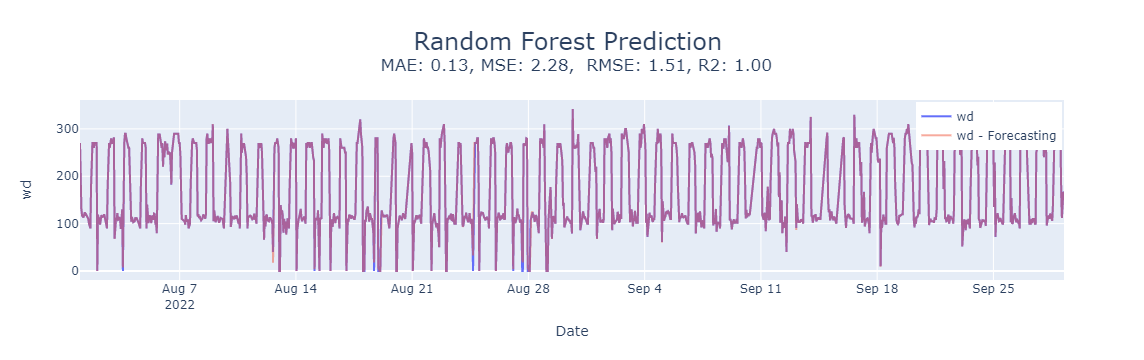

In [117]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x = y_test.index, y = y_test.values, mode='lines', name='wd'))
fig.add_trace(go.Scatter(x = y_test.index, y = y_pred, mode='lines', name='wd - Forecasting', opacity=0.5))
fig.update_layout(title_text=f'Random Forest Prediction <br> <sup> MAE: {MAE_rf:.2f}, MSE: {MSE_rf:.2f},  RMSE: {RMSE_rf:.2f}, R2: {R2_rf:.2f} </sup>',
                  title_font_size=24, title_x=0.5)
fig.update_yaxes(title_text="wd")
fig.update_xaxes(title_text="Date")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.85
))
fig.show()